# Experimenting with Bactesting Investment Strategies

## Strategies

1. Buy and hold. You are given a lump sum and you invest it right away

2. Buy and hold, with buy downturns (aka buy the dip)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from backtesting_dev import DollarCostAveraging, DollarCostAveragingBuyDrawdown
from query_stocks import query_stock_prices
import random

import numpy as np
import plotly.graph_objects as go

In [2]:
plt.style.use('seaborn-v0_8-pastel')

random.seed(456)
# set seed above to 456
# expected profit: 24505.021713256847
# this is for down turn strategy as it buys on chance sometimes

In [3]:
DOWNLOAD_DATA = False

In [4]:
if DOWNLOAD_DATA:
    start = datetime.date(2014, 1, 1)
    end = datetime.date(2024, 1, 1)
    data = query_stock_prices(['VOO'], start_date=start, end_date=end)
    voo_df = data.to_frame("VOO").reset_index()
    voo_df.to_csv("data/voo_df.csv", index=False)

else:
    voo_df = pd.read_csv("data/voo_df.csv")
    voo_df['Date'] = pd.to_datetime(voo_df['Date'])

voo_df['sma_50'] = voo_df['VOO'].rolling(50).mean()

In [5]:
voo_df = voo_df.loc[(pd.Timestamp(2017, 1, 1) <= voo_df['Date'])]

## Basic Buy and Hold Strategy

tl;dr Immediately buy as much as possible. Don't think, just buy.

In [6]:
buyandhold = DollarCostAveraging('VOO', monies = 10000, income=1000)
buyandhold.run(data=voo_df)

1760it [00:00, 3691.34it/s]


In [7]:
holdings = buyandhold.holdings.to_pandas()
profit_buyandhold = holdings['quantity']*(buyandhold.end_price - holdings['price'])
print("PROFIT: {:,.2f}".format(profit_buyandhold.sum())) #PROFIT: 102,904.19

PROFIT: 49,360.67


In [8]:
holdings

,symbol,price,quantity,date
0,VOO,206.740005,48.0,2017-01-03
1,VOO,208.970001,5.0,2017-01-31
2,VOO,217.070007,4.0,2017-02-28
3,VOO,216.350006,5.0,2017-03-31
4,VOO,218.600006,4.0,2017-04-28
...,...,...,...,...
84,VOO,413.829987,2.0,2023-08-31
85,VOO,392.700012,3.0,2023-09-29
86,VOO,384.170013,2.0,2023-10-31
87,VOO,419.399994,2.0,2023-11-30


In [9]:
ts_voo = voo_df.set_index('Date')

In [10]:
ts_holdings_1 = holdings.set_index('date') #.asfreq('D')

In [11]:
ts_voo = pd.concat([ts_voo, ts_holdings_1['price']], axis=1)

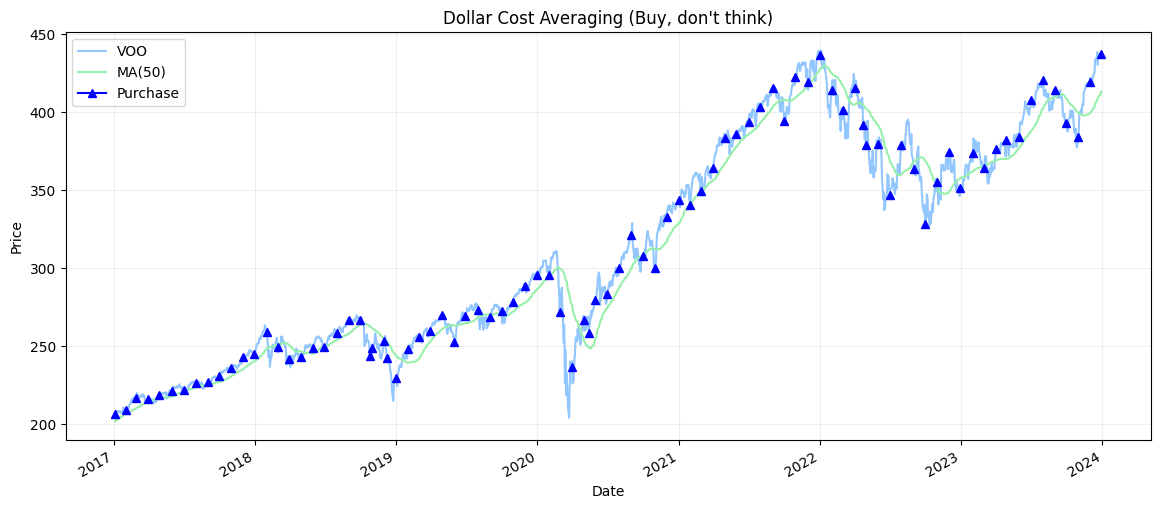

In [12]:
fig, ax = plt.subplots(figsize = (14, 6))
ts_voo['VOO'].plot(ax=ax, label='VOO')
ts_voo['sma_50'].plot(ax=ax, label='MA(50)')
ts_voo['price'].plot(marker='^', ax=ax, label='Purchase', color='blue')
ax.legend()
ax.set_title("Dollar Cost Averaging (Buy, don't think)")
ax.set_ylabel("Price")
ax.set_xlabel("Date")
ax.grid(alpha=0.2)


In [13]:
buyandhold.end_price*holdings['quantity'].sum() , buyandhold.contributions.sum()

(143270.39599609378, 94000)

In [14]:
buyandhold.end_price*holdings['quantity'].sum() / buyandhold.contributions.sum() - 1

0.5241531488946147

In [15]:
fig = go.Figure(
    layout=dict(
        title=go.layout.Title(text="Dollar Cost Averaging", xanchor='center', yanchor='top', x=0.5, y=0.9, font=dict(size=25)),
        height=550
        )
    )
fig.update_layout(xaxis_title="Date", yaxis_title="Price ($)", legend_title="Legend", font = dict(size=15))
#fig.update_layout(template='plotly_white')
#fig.update_layout(paper_bgcolor="white", plot_bgcolor="white")
# Add traces
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['VOO'],
                    mode='lines',
                    name='VOO'))
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['price'],
                    mode='markers', # lines+markers available too
                    marker=go.scatter.Marker(symbol='triangle-up', size=10, color='magenta'),
                    name='Purchases'))
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['sma_50'],
                    mode='lines',
                    line={'dash': 'dash'},
                    name='MA(50)'))
fig.show()

In [16]:
del ts_voo

## Downturn Strategy

In [17]:
drawdown = DollarCostAveragingBuyDrawdown('VOO', monies=10000, income=1000)
drawdown.run(data=voo_df)

1760it [00:00, 3768.65it/s]


In [18]:
newholdings = drawdown.holdings.to_pandas()
profit_drawdown = newholdings['quantity']*(drawdown.end_price - newholdings['price'])
print("DRAWDOWN STRATEGY PROFIT: {:,.2f}".format(profit_drawdown.sum()))

DRAWDOWN STRATEGY PROFIT: 48,282.99


In [19]:
print("BUY AND HOLD PROFIT: {:,.2f}".format(profit_buyandhold.sum()))

BUY AND HOLD PROFIT: 49,360.67


In [20]:
ts_voo = voo_df.set_index('Date')

In [21]:
ts_holdings_2 = newholdings.set_index('date') #.asfreq('D')

In [22]:
ts_voo = pd.concat([ts_voo, ts_holdings_2[['price', 'quantity']]], axis=1)

In [23]:
ts_voo.head()

,VOO,sma_50,price,quantity
2017-01-03,206.740005,201.881801,206.740005,10.0
2017-01-04,207.960007,202.111601,NaN,NaN
2017-01-05,207.800003,202.322201,NaN,NaN
2017-01-06,208.610001,202.560201,NaN,NaN
2017-01-09,207.949997,202.793801,NaN,NaN


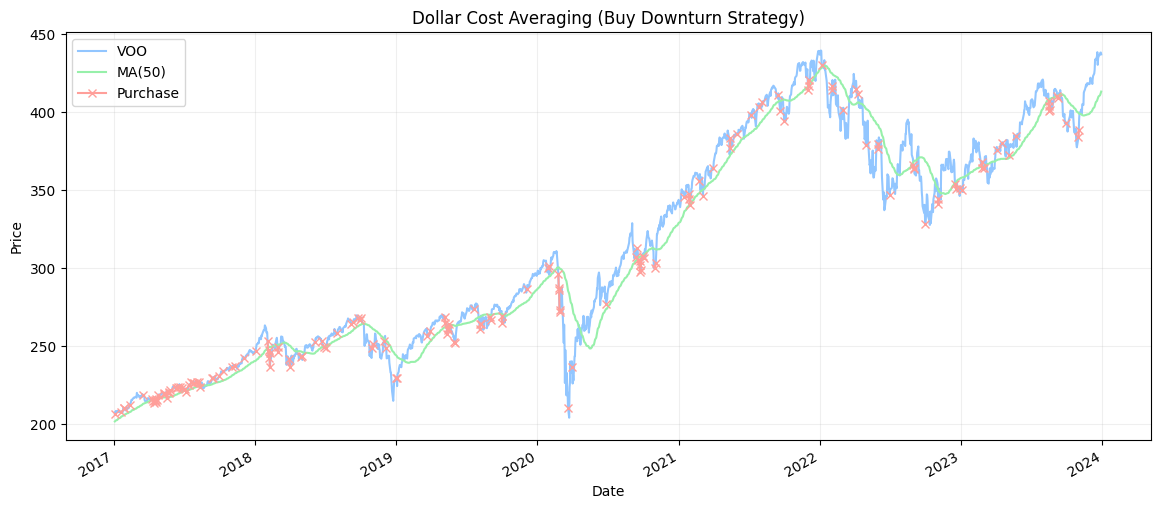

In [24]:
fig, ax = plt.subplots(figsize = (14, 6))
ts_voo['VOO'].plot(ax=ax, label='VOO')
ts_voo['sma_50'].plot(ax=ax, label='MA(50)')
ts_voo['price'].plot(marker='x', ax=ax, label='Purchase', markersize=6)
ax.legend()
ax.set_title("Dollar Cost Averaging (Buy Downturn Strategy)")
ax.set_ylabel("Price")
ax.set_xlabel("Date")
ax.grid(alpha=0.2)


In [26]:
drawdown.end_price*newholdings['quantity'].sum() , drawdown.contributions.sum()

(140212.796081543, 94000)

In [27]:
drawdown.end_price*newholdings['quantity'].sum() / drawdown.contributions.sum() - 1

0.4916254902291808

In [28]:
fig = go.Figure(
    layout=dict(
        title=go.layout.Title(text="Dollar Cost Averaging with Downturn", xanchor='center', yanchor='top', x=0.5, y=0.9, font=dict(size=25)),
        height=550
        )
    )
fig.update_layout(xaxis_title="Date", yaxis_title="Price ($)", legend_title="Legend", font = dict(size=15))#fig.update_layout(template='plotly_white')
#fig.update_layout(paper_bgcolor="white", plot_bgcolor="white")
# Add traces
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['VOO'],
                    mode='lines',
                    name='VOO'))
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['price'],
                    mode='markers', # lines+markers available too
                    marker=go.scatter.Marker(symbol='triangle-up', size=10, color='magenta'),
                    name='Purchases'))
fig.add_trace(go.Scatter(x=ts_voo.index, y=ts_voo['sma_50'],
                    mode='lines',
                    line={'dash': 'dash'},
                    name='MA(50)'))
fig.show()

In [29]:
# #combined plots
# N=100
# random_x = np.linspace(0, 5, N)
# random_y0 = np.random.randn(N) + 5
# random_y1 = np.random.randn(N)
# random_y2 = np.random.randn(N) - 5
# fig = go.Figure()
# # Add traces
# fig.add_trace(go.Line(x=random_x, y=random_y0))
# fig.add_trace(go.Scatter(x=random_x, y=random_y1,
#                     mode='markers',
#                     name='markers'))
# fig.add_trace(go.Scatter(x=random_x, y=random_y2,
#                     mode='lines',
#                     name='lines'))
# fig.show()

In [30]:
#help(go.Scatter)